In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Lecture 05 - Multiple Hidden Layer

- Moons Dataset
- Decision Boundary
- Loss curve
- Sigmoid, Tanh

<img src='../../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align = "left"/>

## Import Statements

In [4]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Setup Global Parameters

In [6]:
###----------------
### Some parameters
###----------------

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 20000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [7]:
def fn_plot_decision_boundary(predict, X, y):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize = (8,5))
    
    # Small increment to create object function surface
    dm = 0.01
    
    # Range of X values (First feature)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    # Range of Y values (Second feature)
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a grid to evaluate the object function
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # flatten and stack
    # arrays will be stacked along their last axis after being upgraded to at least 2-D 
    # with 1’s post-pended to the shape (column vectors made out of 1-D arrays)
    XX = np.c_[xx.ravel(), yy.ravel()] 
    
    # list to collect predictions
    Z = predict(XX)
        
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k', cmap=plt.cm.bwr)
    ax.set_title('Decision Boundary')

    ax.set_xlabel('A')
    ax.set_ylabel('B')
    plt.show()

## Generate Data Set
<div style="font-family: Arial; font-size:1.2em">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [9]:
X, y = datasets.make_moons(n_samples=N_SAMPLES,
                           noise=NOISE, 
                           shuffle=True, 
                           random_state=RANDOM_STATE)
# X, y = datasets.make_circles(n_samples=N_SAMPLES,
#                            noise=NOISE, 
#                            shuffle=True, 
#                            random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0], dtype=int64))

In [10]:
data_df = pd.DataFrame(X, columns=['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [12]:
data_df.describe()

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


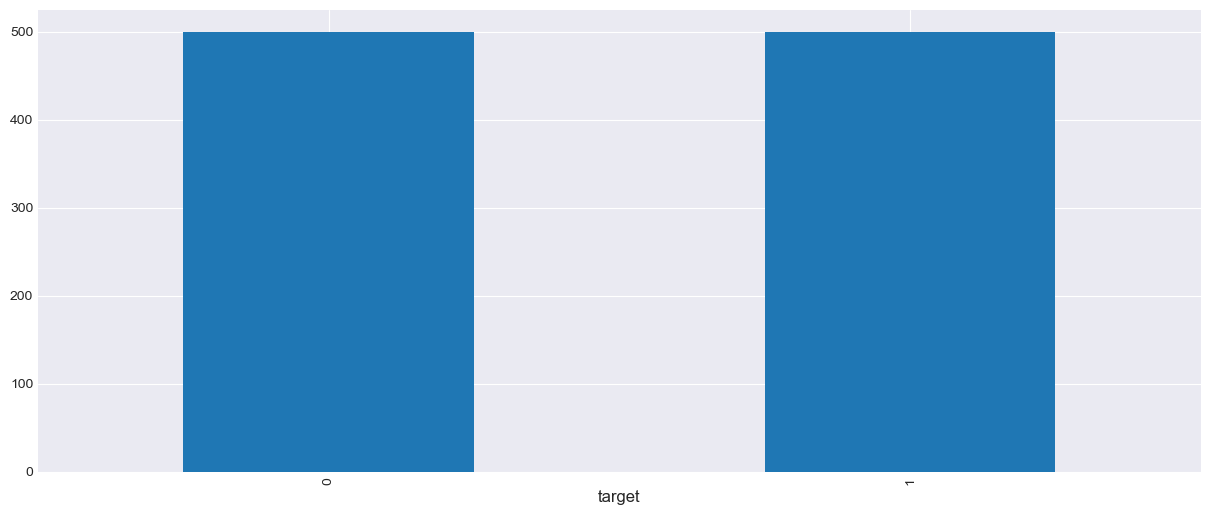

In [13]:
data_df['target'].value_counts().plot(kind = 'bar');

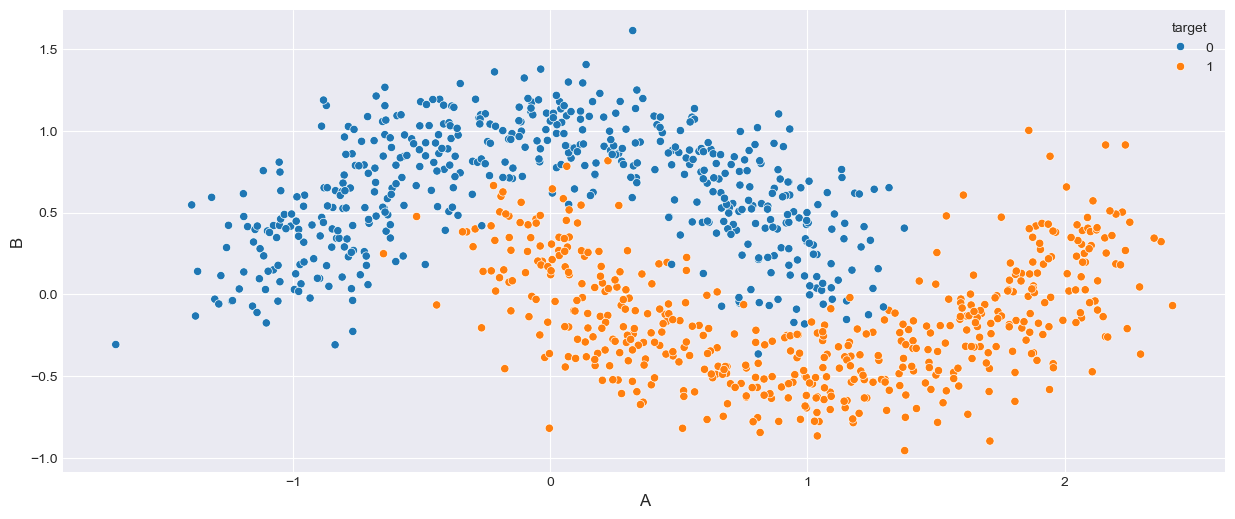

In [14]:
ax = sns.scatterplot(data=data_df, x='A', y='B', hue='target')

# Convert to one hot encoding

In [16]:
y = pd.get_dummies(y).to_numpy()
y.shape

(1000, 2)

In [17]:

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800, 2), (200, 2))

### One hidden layer


### Activation Functions
#### Softmax Function

In [20]:
def fn_softmax(z):
    exp_sc = np.exp(z - np.max(z))  # max subtracted to avoid overflow
    return exp_sc /np.sum(exp_sc, axis=1, keepdims=True)

In [21]:
# Unit Testing
fn_softmax(np.array([[-1., 0., 1.0], [-10, 0, 10]]))  

array([[9.00305732e-02, 2.44728471e-01, 6.65240956e-01],
       [2.06106005e-09, 4.53978686e-05, 9.99954600e-01]])

In [22]:
# def fn_sigmoid(z):

#     return 1 /(1+ np.exp(-z))

In [23]:
#fn_sigmoid(np.array([[-1., 0., 1.0], [-np.inf, 0, np.inf]]))

#### TanH Activation

In [25]:
def fn_actv(z):
    return np.tanh(z)

def fn_actv_prime(a):
    return 1.0 - np.tanh(a)**2

In [26]:
fn_actv(np.array([[-1., 0., 1.0], [-np.inf, 0, np.inf]]))

array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

In [27]:
1- np.tanh(-1)**2

0.41997434161402614

In [28]:
def predict(model, X_p):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    W3, b3, W4, b4 = model['W3'], model['b3'], model['W4'], model['b4']
    W5, b5= model['W5'], model['b5']
    
    ### forward propagation
    #### Layer 1
    z1 = X_p.dot(W1) + b1   # Aggregation 
    a1 = fn_actv(z1)        # Activations

    #### Layer 2
    z2 = a1.dot(W2) + b2   # Aggregation 
    a2 = fn_actv(z2)        # Activations

     #### Layer 3
    z3 = a2.dot(W3) + b3   # Aggregation 
    a3 = fn_actv(z3)        # Activations

    #### Layer 4
    z4 = a3.dot(W4) + b4   # Aggregation 
    a4 = fn_actv(z4)        # Activations

    #### Layer 5
    z5 = a4.dot(W5) + b5    # Aggregation 
    a5 = fn_softmax(z5)     # Activations 

    return np.argmax(a5, axis = 1)

In [29]:
def calculate_loss(model, X_l, y_l):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    W3, b3, W4, b4 = model['W3'], model['b3'], model['W4'], model['b4']
    W5, b5= model['W5'], model['b5']

    m = X_l.shape[0]
    
    ### forward propagation
    #### Layer 1
    z1 = X_l.dot(W1) + b1   # Aggregation 
    a1 = fn_actv(z1)        # Activations

    #### Layer 2
    z2 = a1.dot(W2) + b2   # Aggregation 
    a2 = fn_actv(z2)        # Activations

     #### Layer 3
    z3 = a2.dot(W3) + b3   # Aggregation 
    a3 = fn_actv(z3)        # Activations

    #### Layer 4
    z4 = a3.dot(W4) + b4   # Aggregation 
    a4 = fn_actv(z4)        # Activations

    #### Layer 5
    z5 = a4.dot(W5) + b5    # Aggregation 
    a5 = fn_softmax(z5)     # Activations 
    
    data_loss = -(y_l * np.log(a5)).sum()

    return data_loss / m

In [30]:
def build_model(param : dict,
                 X_t: np.ndarray, 
                y_t : np.ndarray,
                alpha : np.float64 = ALPHA,
                epochs : np.int64  = EPOCHS):
    '''
    Args:
        param: dict : number of nodes in hidden layers
        X_t: np.array : train features
        y_t: np.array : train labels
        alpha: float : learning rate
        epochs: int : number of epochs to train
    Return:
        model : dict          
    '''
    m = X_t.shape[0]
    
    # Defining Weights at random. Pay attention to
    W1 = np.random.rand(param['nn_dim'][0], param['nn_dim'][1]) / np.sqrt(param['nn_dim'][0])
    W2 = np.random.rand(param['nn_dim'][1], param['nn_dim'][2]) / np.sqrt(param['nn_dim'][1])
    W3 = np.random.rand(param['nn_dim'][2], param['nn_dim'][3]) / np.sqrt(param['nn_dim'][2])
    W4 = np.random.rand(param['nn_dim'][3], param['nn_dim'][4]) / np.sqrt(param['nn_dim'][3])
    W5 = np.random.rand(param['nn_dim'][4], param['nn_dim'][5]) / np.sqrt(param['nn_dim'][4])

    b1 = np.zeros((1, param['nn_dim'][1]))
    b2 = np.zeros((1, param['nn_dim'][2]))
    b3 = np.zeros((1, param['nn_dim'][3]))
    b4 = np.zeros((1, param['nn_dim'][4]))
    b5 = np.zeros((1, param['nn_dim'][5]))


    
    curr_loss = 0

    loss = []
    epoch = []

    for i in range(epochs):
        
    
        ### forward propagation
        #### Layer 1
        z1 = X_t.dot(W1) + b1   # Aggregation function
        a1 = fn_actv(z1)        # Activations

        #### Layer 2
        z2 = a1.dot(W2) + b2   # Aggregation function
        a2 = fn_actv(z2)        # Activations

         #### Layer 3
        z3 = a2.dot(W3) + b3   # Aggregation function
        a3 = fn_actv(z3)        # Activations

        #### Layer 4
        z4 = a3.dot(W4) + b4   # Aggregation function
        a4 = fn_actv(z4)        # Activations

        #### Layer 5
        z5 = a4.dot(W5) + b5    # Aggregation function
        a5 = fn_softmax(z5)     # Activations 

        ### Back Propagation
        ## Layer 5
        assert (a5.shape == y_t.shape), f'Shape a5: {a5.shape} and y_t :{y_5.shape}'

        dz5 = a5 - y_t   # a-y
        dW5 = (a4.T).dot(dz5)   # a4 dot dz5
        assert (W5.shape == dW5.shape), f'Shape W5: {W5.shape} and dW5 :{dW5.shape}'

        db5 = np.sum(dz5, axis =0, keepdims=True)
        assert (b5.shape == db5.shape), f'Shape b5: {b5.shape} and db5 :{db5.shape}'

        da4 = dz5.dot(W5.T)
        assert (a4.shape == da4.shape), f'Shape a4: {a4.shape} and da4 :{da4.shape}'
        ##----------------------------------------------------------------------------------

        # 1ayer 4
        dz4 = da4 * fn_actv_prime(z4) # this element wise multiplication
        assert (z4.shape == dz4.shape), f'Shape z4: {z4.shape} and dz4 :{dz4.shape}'

        dW4 = (a3.T).dot(dz4)
        assert (W4.shape == dW4.shape), f'Shape W4: {W4.shape} and dW4 :{dW4.shape}'

        db4 = np.sum(dz4, axis =0, keepdims=True)
        assert (b4.shape == db4.shape), f'Shape b4 : {b4.shape} and db4 :{db4.shape}'

        da3 = dz4.dot(W4.T)
        assert (a3.shape == da3.shape), f'Shape a3: {a3.shape} and da3 :{da3.shape}'
        ##----------------------------------------------------------------------------------

        # 1ayer 3
        dz3 = da3 * fn_actv_prime(z3) # this element wise multiplication
        assert (z3.shape == dz3.shape), f'Shape z3: {z3.shape} and dz3 :{dz3.shape}'

        dW3 = (a2.T).dot(dz3)
        assert (W3.shape == dW3.shape), f'Shape W3: {W3.shape} and dW3 :{dW3.shape}'

        db3 = np.sum(dz3, axis =0, keepdims=True)
        assert (b3.shape == db3.shape), f'Shape b3 : {b3.shape} and db3 :{db3.shape}'

        da2 = dz3.dot(W3.T)
        assert (a2.shape == da2.shape), f'Shape a2: {a2.shape} and da2 :{da2.shape}'
        ##----------------------------------------------------------------------------------

        # 1ayer 2
        dz2 = da2 * fn_actv_prime(z2) # this element wise multiplication
        assert (z2.shape == dz2.shape), f'Shape z2: {z2.shape} and dz2 :{dz2.shape}'

        dW2 = (a1.T).dot(dz2)
        assert (W2.shape == dW2.shape), f'Shape W2: {W2.shape} and dW2 :{dW2.shape}'

        db2 = np.sum(dz2, axis =0, keepdims=True)
        assert (b2.shape == db2.shape), f'Shape b2 : {b2.shape} and db2 :{db2.shape}'

        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), f'Shape a1: {a1.shape} and da1 :{da1.shape}'
        ##----------------------------------------------------------------------------------

        ## Layer 1
        dz1 = da1 * fn_actv_prime(z1) # this element wise multiplication
        assert (z1.shape == dz1.shape), f'Shape z1: {z1.shape} and dz1 :{dz1.shape}'

        dW1 = (X_t.T).dot(dz1)
        assert (W1.shape == dW1.shape), f'Shape W1: {W1.shape} and dW1 :{dW1.shape}'

        db1 = np.sum(dz1, axis =0, keepdims=True)
        assert (b1.shape == db1.shape), f'Shape b1 : {b1.shape} and db1 :{db1.shape}'
        

        W1 += -alpha * dW1 /m
        W2 += -alpha * dW2 /m
        W3 += -alpha * dW3 /m
        W4 += -alpha * dW4 /m
        W5 += -alpha * dW5 /m
        
        b1 += -alpha * db1 /m
        b2 += -alpha * db2 /m
        b3 += -alpha * db3 /m
        b4 += -alpha * db4 /m
        b5 += -alpha * db5 /m

        model = {'W1': W1,
                 'b1': b1,
                 'W2': W2,
                 'b2': b2,
                 'W3': W3,
                 'b3': b3,
                 'W4': W4,
                 'b4': b4,
                 'W5': W5,
                 'b5': b5}
        
        if i%100 == 0:
            curr_loss = calculate_loss(model=model, X_l=X_t, y_l=y_t)
            loss.append(curr_loss)
            epoch.append(i)

        if i%1000 == 0:
            print (f'Loss after {i:5d} epoch : {curr_loss: 9.4f}')
            
    loss_hist['loss'] = loss
    loss_hist['epoch'] = epoch
    return model

In [31]:
layer_param = {}
input_dim = X_train.shape[1]
out_dim = y_train.shape[1]
layer_param['nn_dim'] = [input_dim, 5, 5, 4, 3, out_dim]

In [32]:
loss_hist = {}

In [33]:
model = build_model(layer_param, X_train, y_train, ALPHA, EPOCHS)

Loss after     0 epoch :    0.6894
Loss after  1000 epoch :    0.0904
Loss after  2000 epoch :    0.0774
Loss after  3000 epoch :    0.0762
Loss after  4000 epoch :    0.0756
Loss after  5000 epoch :    0.0753
Loss after  6000 epoch :    0.0749
Loss after  7000 epoch :    0.0746
Loss after  8000 epoch :    0.0743
Loss after  9000 epoch :    0.0739
Loss after 10000 epoch :    0.0735
Loss after 11000 epoch :    0.0731
Loss after 12000 epoch :    0.0726
Loss after 13000 epoch :    0.0721
Loss after 14000 epoch :    0.0715
Loss after 15000 epoch :    0.0710
Loss after 16000 epoch :    0.0705
Loss after 17000 epoch :    0.0700
Loss after 18000 epoch :    0.0695
Loss after 19000 epoch :    0.0691


In [34]:
# model['W1'].shape, model['W2'].shape, model['b1'].shape, model['b2'].shape

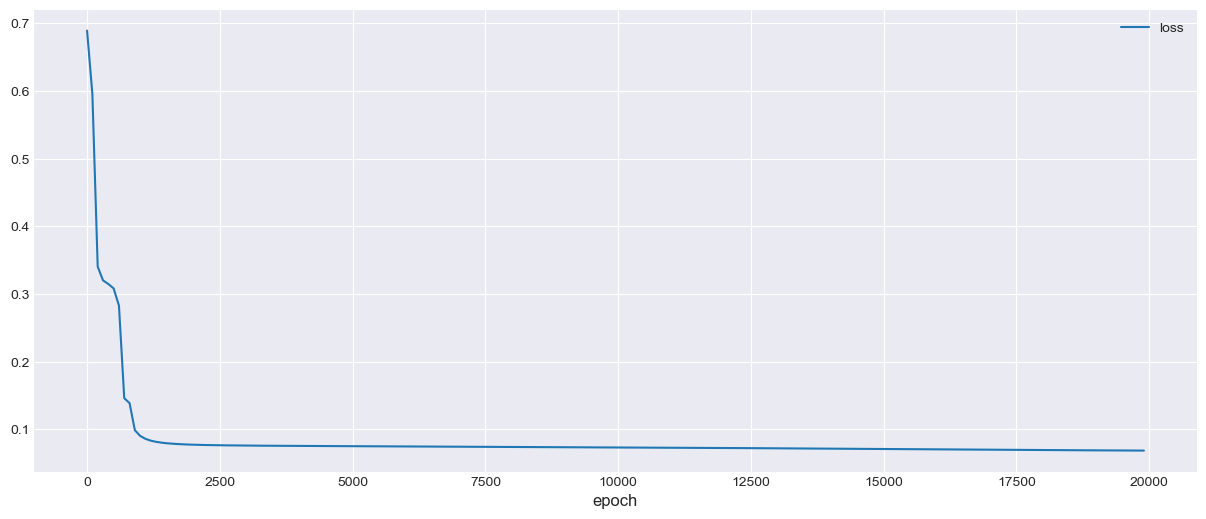

In [35]:
pd.DataFrame(loss_hist).plot(x='epoch', y='loss');

### Training Data

In [37]:
y_pred = predict(model, X_train)

accuracy_score(y_pred=y_pred, y_true=np.argmax(y_train, axis=1))

0.97375

In [43]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_train.argmax(axis=1))
cm

array([[387,  13],
       [  8, 392]], dtype=int64)

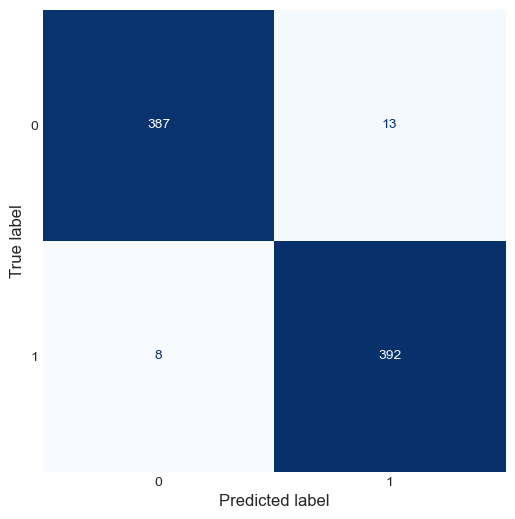

In [45]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot(cmap='Blues', colorbar=False)
plt.grid()
plt.show()

### Testing Data

Test Accuracy: 0.98


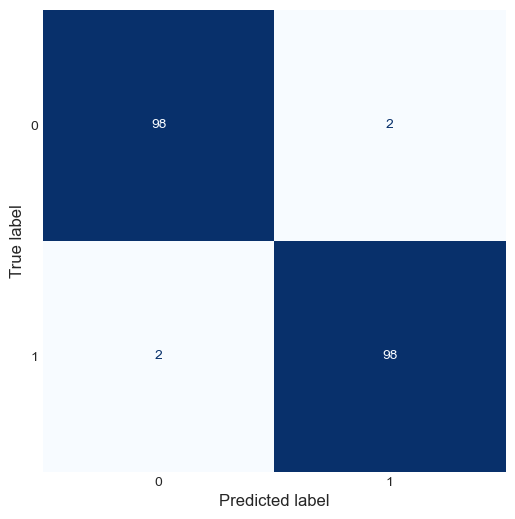

In [47]:
y_pred = predict(model, X_test)


# calculate accuracy
print (f'Test Accuracy: {accuracy_score(y_pred=y_pred, y_true=y_test.argmax(axis=1))}')

# calculate confusion matrix
cm = confusion_matrix(y_pred=y_pred, y_true=y_test.argmax(axis=1))

# plots always look good
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot(cmap='Blues', colorbar=False)
plt.grid()
plt.show()

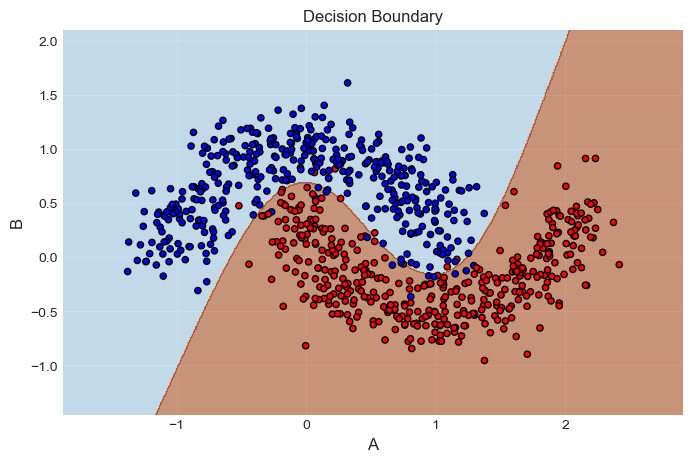

In [53]:
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train.argmax(axis=1))